In [1]:
import random
import torch
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from torchvision import io, transforms
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [47]:
IMAGE_HEIGHT, IMAGE_LENGTH = 28, 28 #112, 112 #12, 16 #60, 80 #120, 160

In [48]:
def read_data(dataset: list):
    """dataset: 'train', 'val', or 'test'. Read in and return list of image
    tensors (X) and list of int labels (y)"""
    label = {"normal": 0, "pneumonia": 1}
    upper = {"normal": "NORMAL", "pneumonia": "PNEUMONIA"}
    
    rows = []
    for clf in label.keys(): # for each label (normal and pneumonia)
        with open(f"chest_xray/{clf}_{dataset}.txt") as file:  # read in names 
            for line in file.readlines():
                image_name = line.strip()  # remove '\n' at end of string
                image = io.read_image(f"chest_xray/{dataset}/{upper[clf]}/{image_name}") # tensor
                # ex: "chest_xray/test/NORMAL/image_name.txt"
                if image.shape[0] == 1:  # some images have three dimensions
                    rows.append([image, label[clf]])

    random.shuffle(rows)
    images, labels = [e[0] for e in rows], [e[1] for e in rows]  # split into X and y
    return images, labels

In [49]:
X_train, y_train = read_data("train")
X_val, y_val = read_data("val")
X_test, y_test = read_data("test")

In [50]:
X_train_new = [transforms.Resize([IMAGE_HEIGHT, IMAGE_LENGTH])(X_train[i]) for i in range(len(X_train))]
X_val_new = [transforms.Resize([IMAGE_HEIGHT, IMAGE_LENGTH])(X_val[i]) for i in range(len(X_val))]
X_test_new = [transforms.Resize([IMAGE_HEIGHT, IMAGE_LENGTH])(X_test[i]) for i in range(len(X_test))]

In [51]:
X_train_new1 = torch.stack(X_train_new)
X_val_new1 = torch.stack(X_val_new)
X_test_new1 = torch.stack(X_test_new)

In [52]:
len(X_test_new)

624

In [53]:
batch_size = 8# 64

train_dataset = torch.utils.data.TensorDataset(X_train_new1, torch.tensor(y_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=True)

test_dataset = torch.utils.data.TensorDataset(X_test_new1, torch.tensor(y_test))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=True)

In [25]:
input_size = 1 * IMAGE_HEIGHT * IMAGE_LENGTH  # input spatial dimension of images
hidden_size = 256 #128         # width of hidden layer
output_size = 2          # number of output neurons

class PneumoniaClassifier(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)
        self.cv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2) # 6, 28, 28
        
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.act = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.log_softmax = torch.nn.Softmax(dim=1)
     
    def forward(self, x):
        # Input image is of shape [batch_size, 1, IMAGE_, 28]
        #print(x)
        x = self.cv1(x.float())
        #print(x)
        x = self.flatten(x)  # Need to flatten to [batch_size, 784] before feeding to fc1

        #y_output = x
        y = self.fc1(x.float())
        y = self.act(y)
        y = self.fc2(y)
        y_output = self.log_softmax(y)
        return y_output

model = PneumoniaClassifier().to(DEVICE)

# sanity check
#print(model)

In [64]:
input_size = 1 * IMAGE_HEIGHT * IMAGE_LENGTH  # input spatial dimension of images
hidden_size = 256 #128         # width of hidden layer
output_size = 2          # number of output neurons

class PneumoniaClassifier(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.c1 = torch.nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=2)
        self.c2 = torch.nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1,padding=0)
        self.c3 = torch.nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5,stride=1,padding=0)
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.relu = torch.nn.ReLU()
        
        self.fc1 = torch.nn.Linear(in_features=120,out_features=84)
        self.fc2 = torch.nn.Linear(in_features=84,out_features=output_size)
        
     
    def forward(self, x):
        x = self.c1(x)
        x = self.relu(self.max_pool(x))
        x = self.c2(x)
        x = self.relu(self.max_pool(x))
        x = self.relu(self.c3(x))
        x = torch.flatten(x,1)
        x = self.relu(self.fc1(x))
        y = self.fc2(x)
        return y

model = PneumoniaClassifier().to(DEVICE)

# sanity check
#print(model)

In [26]:
input_size

192

In [60]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.float().to(device), label#.to(device)

        optimizer.zero_grad()
        outputs = model(img)
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(outputs, label)
        #loss = torch.nn.CrossEntropyLoss(outputs, label)
        
        loss.backward()
        optimizer.step()
    
        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    return losses, counter

In [61]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            #img, label = img.to(device), label#.to(device)

            output = model(img)
            #pred = None # Get index of largest log-probability and use that as prediction
            preds = [np.argmax(row) for row in output]
            num_correct += sum([1 for pred, true in zip(preds, label) if pred == true])
            criterion = torch.nn.CrossEntropyLoss()
            test_loss += criterion(output, label)
            
    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

In [65]:
# Hyperparameters
lr = 0.01
max_epochs=10
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_counter = []
test_losses = []
test_correct = []
for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)

    # Record results
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    test_losses.append(test_loss)
    test_correct.append(num_correct)

print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")

Epochs:   0%|                                            | 0/10 [00:03<?, ?it/s]


RuntimeError: expected scalar type Byte but found Float

In [30]:
print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")
test_correct
test_losses

Test accuracy: 0.625


[tensor(0.0860),
 tensor(0.0860),
 tensor(0.0860),
 tensor(0.0860),
 tensor(0.0860),
 tensor(0.0860),
 tensor(0.0860),
 tensor(0.0860),
 tensor(0.0860),
 tensor(0.0860)]

In [31]:
print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")

Test accuracy: 0.625


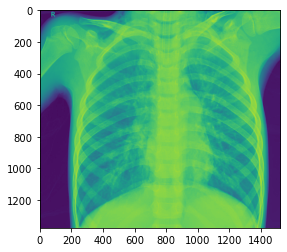

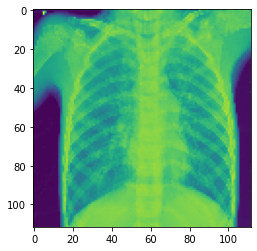

In [39]:
def show_image_resize(rand_idx):
    """Show the image resize using global variables for height / weight"""
    plt.imshow(X_train[rand_idx][0])
    plt.show()
#    plt.imshow(transforms.Resize([IMAGE_HEIGHT, IMAGE_LENGTH])(X_train[rand_idx])[0])
    plt.imshow(transforms.Resize([112, 112])(X_train[rand_idx])[0])
    
show_image_resize(7)